# Exploring COVID-19 Cases in the US
#### Author: Victor Cannestro

### Imports

In [1]:
import numpy as np
import pandas as pd
import missingno as msn

import geopandas
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import seaborn as sns
sns.set(font_scale=1.5) 

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from bs4 import BeautifulSoup
import requests

# Code to center plots in the screen
from IPython.core.display import HTML 
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Exploring the Time-Series

First, we import the county level time-series data gathered by the **NY Times** on Github (without downloading it) using `pd.read_csv()` and parse the retrieved data into an organized, multi-indexed `DataFrame`. The resulting DataFrame will be indexed by `state`, `county`, and `date` and have three columns: `fips`, `cases`, and `deaths`. Here, `fips` stands for the __F__ederal __I__nformation __P__rocessing __S__eries which are the codes most commonly used by the US Census Bureau. To download the data directly into the current working directory, instead, one could call 

```python
import urllib

url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
filename = 'myfilename.csv'
urllib.request.urlretrieve(url, filename)
```

#### Pandas reminders:
[read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [DataFrame()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html), [concat()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html#pandas.concat)

In [2]:
# URL to NY Times COVID-19 data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

# Read the values, set the indices, parse the dates, and alphabetize
df = pd.read_csv(url, 
                 header=0, 
                 index_col=['state','county','date'], 
                 parse_dates=True).sort_index()

df.sample(5)

,,,fips,cases,deaths
state,county,date,,,
New Jersey,Essex,2020-07-13,34013.0,19288,2077
Kentucky,Henderson,2020-05-23,21101.0,103,4
Ohio,Ashtabula,2020-07-07,39007.0,436,44
California,Humboldt,2020-06-17,6023.0,108,4
Ohio,Meigs,2020-07-26,39105.0,23,0


Before moving on with further processing let's check to see if there are any missing or suspect values (like negative cases or deaths) in the data and correct them.

In [3]:
neg_cases = df.cases.values[df.cases.values < 0]
assert set(neg_cases) == set(), 'FAILED: there is a negative value' 

In [4]:
assert len(df[df.cases.isna()]) == 0, 'FAILED: there is a nan value' 

In [5]:
neg_deaths = df.deaths.values[df.deaths.values < 0]
assert set(neg_deaths) == set(), 'FAILED: there is a negative value' 

In [6]:
assert len(df[df.deaths.isna()]) == 0, 'FAILED: there is a nan value' 

We can immediately see how easy is is to look up state and county level information using this indexing scheme. Moreover, because the index is sorted by date (which is a collection of `datetime` objects) as well as alphabetically by state and county we can easily isolate the time-series data for each county in preparation for further analysis, genreating choropleths, etc. For example, let's peak at the latest King County, WA data:

In [7]:
king = df.loc[('Washington','King')] # See the latest data for King County
king.tail()

,fips,cases,deaths
date,,,
2020-07-28,53033.0,14748,667
2020-07-29,53033.0,14898,667
2020-07-30,53033.0,15058,668
2020-07-31,53033.0,15216,668
2020-08-01,53033.0,15418,674


Notice how the `cases` and `deaths` columns are expressed as the running aggregate values instead of new reported cases and deaths. Let's write a function that will accept the DataFrame and columns we're interested in and compute the difference between consecutive days.

In [8]:
king.tail()

,fips,cases,deaths
date,,,
2020-07-28,53033.0,14748,667
2020-07-29,53033.0,14898,667
2020-07-30,53033.0,15058,668
2020-07-31,53033.0,15216,668
2020-08-01,53033.0,15418,674


In [9]:
king.index[-1]

Timestamp('2020-08-01 00:00:00')

In [10]:
def dailyChanges(dataframe, cols):
    '''
    Args:  
        dataframe (pandas DataFrame): the input dataframe of cumulative updates. 
                                      Must be single indexed.
        cols (list): list of column labels
        
    Returns:       
        (pandas DataFrame): quantizing the difference between daily values as
                            the number of new cases per day
    
    Notes: Calculates array subtraction for each date in the Time Series 
           i.e.
    
           changes = df_today_values - df_yesterday_values
           
           This method utilizes the underlying numpy arrays so no for-loops are needed 
           and ought to be faster. The old method was based on elementwise subtraction:
           
           new  = [dataframe[cols].iloc[0]]
    
           # Loop over each date and take the differences
           for i in range(1, len(dataframe)):
               new.append(dataframe[cols].iloc[i] - dataframe[cols].iloc[i-1])

           # Convert new into a DataFrame the same indices as dataframe
           new_df = pd.DataFrame(data=new, index=dataframe.index)
           
    '''
    data = dataframe[cols]
    
    # 1xlen(cols) pad of zeros for first element
    pad = pd.DataFrame({k:0 for k in cols}, index=[dataframe.index[0]]) 
    
    # Drop the last value this means the DF stops at second to last date
    temp = data.drop(data.index[-1]) 
    
    # Relabel the index so every value is dated one day ahead (needed for the subtraction later)
    temp.index = data.index[1:]
    
    # glue the zero pad to temp
    pd.concat((pad, temp)) 
    
    # Element wise calculation of the daily changes (dates need to match up)
    changes = data - temp 
    
    # Edit the column names to reflect the daily changes
    changes.columns = ['new_' + name for name in cols]
    
    return changes

In [11]:
daily_king = dailyChanges(df.loc[('Washington','King')], ['cases','deaths']).apply(abs)
daily_king.tail()

,new_cases,new_deaths
date,,
2020-07-28,110.0,3.0
2020-07-29,150.0,0.0
2020-07-30,160.0,1.0
2020-07-31,158.0,0.0
2020-08-01,202.0,6.0


The summary statistics of these daily change columns provide us with some broad insights about how King County is being affected:
- `mean` 
   - The average number of reported new cases $\approx 97$
   - The average number of reported new deaths $\approx 5$
   
- `max` 
   - The most reported new cases $\approx 269$
   - The most reported new deaths $\approx 19$
   
- $\dots$

In [12]:
daily_king.describe()

,new_cases,new_deaths
count,155.000000,155.000000
mean,99.929032,4.438710
std,62.793116,4.003381
min,0.000000,0.000000
25%,50.000000,1.000000
50%,93.000000,3.000000
75%,145.000000,6.000000
max,269.000000,19.000000


Excellent, now we can use the information within `king` to make a variety of graphs ([bar](https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.bar.html), [step](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.step.html), [etc](https://matplotlib.org/3.1.0/gallery/color/named_colors.html).) to better understand the dynamics of the virus over time and spot any trends that may appear.

In [13]:
def smoother(dataframe, cols, N=7):
    '''
    Args:  
        dataframe (pandas DataFrame): the input dataframe of cumulative updates
        cols (list): column labels
        N (int >= 0): number of days to average
        
    Returns:       
        new (pandas DataFrame): smoothed 7-day rolling average
    
    Notes:
        To calculate the n-day average we make use of a generator 
        expression for readibility and to save memory
        
        https://www.python.org/dev/peps/pep-0289/
    '''
    new  = []
    
    # Loop over each date and take the differences
    for i in range(N, len(dataframe)):       
        # Generator expression to compute the sum
        ave = sum(dataframe[cols].iloc[i-k] for k in [*range(N)]) / N
        new.append(ave)
            
    # Get the indices of the data after the initial N-days and make DataFrame
    idx = dataframe.index[N: len(dataframe)]
    calc = pd.DataFrame(data=new, index=idx)
    
    # Append the averaged data to the initial N-days
    temp = dataframe[cols].iloc[:N].append(calc)
    
    # Edit the column name(s) in temp to include 'average'
    temp.columns = ['average_' + name for name in cols]
    
    return temp

In [14]:
smoothed = smoother(daily_king, ['new_cases','new_deaths'], 7)
smoothed.tail(3)

,average_new_cases,average_new_deaths
date,,
2020-07-30,174.428571,1.285714
2020-07-31,164.285714,0.857143
2020-08-01,163.428571,1.571429


To make the [dates on the x-axis look more appealing](https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/) we will use the `DateFormatter` module from `matplotlib` to customize the display format: `"%X %X"` where each `%X`  represents:

Syntax | Meaning | Example: (July 2020)
---|---|---
`%Y` | 4 digit year | 2020
`%y` | 2 digit year | 20
`%m` | month as a number | 07
`%b` | month as abbreviated name | Jul


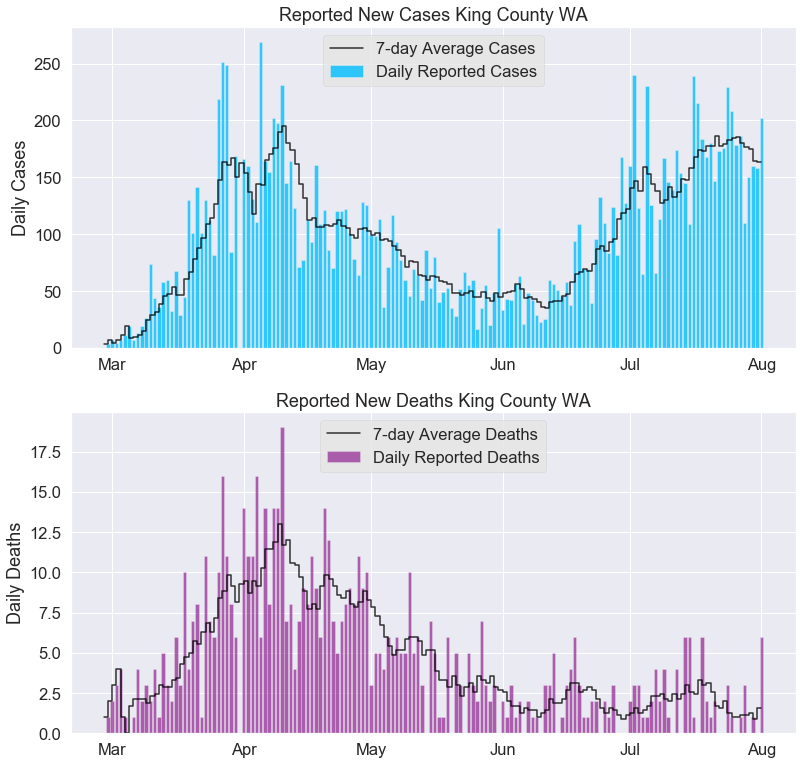

In [15]:
fig, ax = plt.subplots(2, figsize=(13,13))

plt.style.use('ggplot')

# Plot the new reported cases
ax[0].bar(daily_king.index, 
           daily_king.new_cases,  
           color='deepskyblue',
           label='Daily Reported Cases',
           alpha=0.8)

ax[0].step(smoothed.index, 
           smoothed.average_new_cases, 
           color='black',
           alpha=0.8,
           label='7-day Average Cases')

# Plot the new reported deaths
ax[1].bar(daily_king.index, 
           daily_king.new_deaths, 
           color='purple',
           label='Daily Reported Deaths',
           alpha=0.6)

ax[1].step(smoothed.index, 
           smoothed.average_new_deaths, 
           color='black',
           alpha=0.8,
           label='7-day Average Deaths')

# Set axis labels and titles
ax[0].set_title('Reported New Cases King County WA', fontsize=18)
ax[0].set_ylabel('Daily Cases', fontsize=18)
ax[1].set_title('Reported New Deaths King County WA', fontsize=18)
ax[1].set_ylabel('Daily Deaths', fontsize=18)

# Format the dates displayed on the xaxis
date_form = DateFormatter("%b")
ax[0].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_formatter(date_form)

# Show the legend and plots
ax[0].legend()
ax[1].legend(loc='upper center')

plt.savefig('figures/Daily_King_County')
plt.show()

## __Action item:__ 
Since all the plotting calls look similar so far I should make a function that takes in a dataframe, list of column names (str) to plot (list), a title (str), line labels (str), figsize (tuple), and axis object to determine if a subplot is needed 

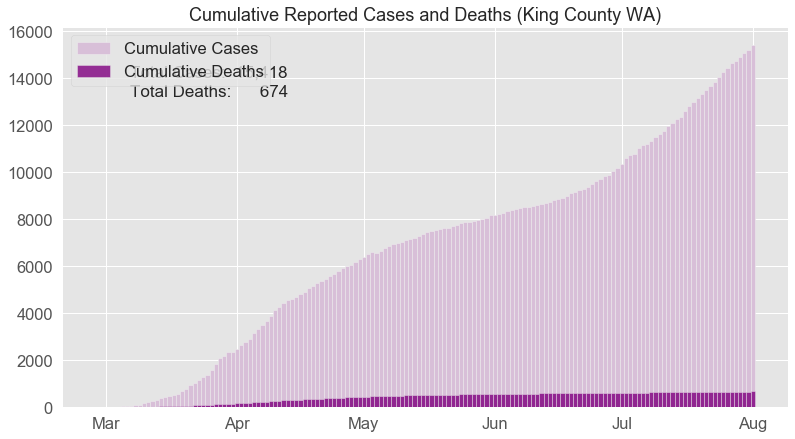

In [16]:
fig, ax = plt.subplots(figsize=(13,7))

plt.style.use('ggplot')

ax.bar(king.index,
       king.cases,
       color='thistle',
       label='Cumulative Cases',
       width=1)

ax.bar(king.index,
       king.deaths,
       color='purple',
       label='Cumulative Deaths',
       width=1,
       alpha=0.8)

ax.set_title('Cumulative Reported Cases and Deaths (King County WA)', fontsize=18)

# Annotate with the total number of cases and deaths. Note that the position is different in the notebook
# and in the saved .png figure. Position for notebook: (75, 332), (75, 312)
ax.annotate('Total Cases:  {:,}'.format(king.cases.values[-1]), (130,362), fontsize=17, xycoords='figure pixels')
ax.annotate('Total Deaths:      {:,}'.format(king.deaths.values[-1]), (130,342), fontsize=17, xycoords='figure pixels')

date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.legend()
plt.savefig('figures/Cumulative_King_County')
plt.show()

### COVID-19 by US Regions

Now we'll filter `df` by regions of the US, however, it's somewhat tedious to keep this record using the full state names. As such, we'll manually add the appropriate postal code labels to a list. Next, we'll grab a mapping of the postal codes and state names from a table made available by the [Natural Resources Conservation Service (NRCS)](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696) using [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and the `requests` module. Finally, we'll [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) the postal codes to `df`. Note that the `fips` columns in the two DataFrames differ. The `fips` codes given by the NRCS are directly compatible with the `.geojson` file we'll be using to make the maps.

In [17]:
# Lists of the regions of the US
northeast = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
midwest = ['IL', 'IN', 'IA', 'KA', 'MI', 'MO', 'MN', 'NE', 'ND', 'OH', 'SD', 'WI']
south = ['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UR', 'WA', 'WY']

In [18]:
url = "https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696"
html_content = requests.get(url).text      # Make a GET request to fetch the raw HTML content
soup = BeautifulSoup(html_content, "lxml") # Parse the html content

fips, countyName, stateName = [], [], []
for tr in soup.find_all('tr')[29:-6]: #Found bounds manually
    tds = tr.find_all('td')
    fips.append(tds[0].text.replace('\r\n\t\t\t\t',''))
    countyName.append(tds[1].text.replace('\r\n\t\t\t\t',''))
    stateName.append(tds[2].text.replace('\r\n\t\t\t\t',''))

statefips = pd.DataFrame()
statefips['name'] = fips
statefips['postal code'] = countyName
statefips['fips'] = stateName
statefips.head()

,name,postal code,fips
0,Alabama,AL,01
1,Alaska,AK,02
2,Arizona,AZ,04
3,Arkansas,AR,05
4,California,CA,06


In [19]:
data = df.reset_index()
data = data.drop('fips', axis=1).merge(statefips, left_on='state', right_on='name', how='inner')
data = data.drop(['name','state'], axis=1).set_index('date').sort_values('date')
data.head()

,county,cases,deaths,postal code,fips
date,,,,,
2020-01-21,Snohomish,1,0,WA,53
2020-01-22,Snohomish,1,0,WA,53
2020-01-23,Snohomish,1,0,WA,53
2020-01-24,Snohomish,1,0,WA,53
2020-01-24,Cook,1,0,IL,17


Now we're ready to subset `data` by regions. Notice that `data`, and therefore `NE`,`S`,`MW`,`W`, have multiple entries for any single date, because the virus spread to multiple locations as time went on. We'll need to aggregate those entries into a single instance of that date describing the number of cases for the entire region on that day before passing it to `dailyChanges()`.

In [20]:
NE = data[data['postal code'].isin(northeast)]
S = data.loc[data['postal code'].isin(south)]
MW  = data.loc[data['postal code'].isin(midwest)]
W = data.loc[data['postal code'].isin(west)]

In [21]:
def sumByDate(dataframe, cols):
    '''
    Args:
        dataframe (DataFrame): A dataframe with multiple entries for 
                               any single date. Indexed by date.
        cols (list): list of columns to consider
        
    Returns:
        aggDF (DataFrame): A dataframe with a single entry for any
                           single date, aggregated by sum
        
    Notes:
    '''
    # Get the unique dates
    idx = dataframe.index.unique()
    sumDF = pd.DataFrame(index=idx, columns=cols)
    for date in idx:
        sumDF.loc[date] = dataframe[cols].loc[date].sum()
    return sumDF

In [22]:
# Aggregate the multiple cases on any one date
sum_NE = sumByDate(NE, ['cases'])
sum_S = sumByDate(S, ['cases'])
sum_MW = sumByDate(MW, ['cases'])
sum_W = sumByDate(W, ['cases'])

In [23]:
# Find the newly reported daily cases 
dailyNE = dailyChanges(sum_NE, ['cases'])
dailyS = dailyChanges(sum_S, ['cases'])
dailyMW = dailyChanges(sum_MW, ['cases'])
dailyW = dailyChanges(sum_W, ['cases'])

The . We'll also add an annotation describing the percentage of the regional population that's been reported as infected with COVID-19 using regional population data from the  [US Census Bureau](https://www.census.gov/popclock/print.php?component=growth&image=//www.census.gov/popclock/share/images/growth_1561939200.png). 

In [40]:
popNE, popS, popMW, popW = 55982803, 68329004, 78347268, 125580448

# Percent of regional population infected
percentW = (dailyW.sum()[0] / popW) * 100
percentMW = (dailyMW.sum()[0] / popMW) * 100
percentNE = (dailyNE.sum()[0] / popNE) * 100
percentS = (dailyS.sum()[0] / popS) * 100

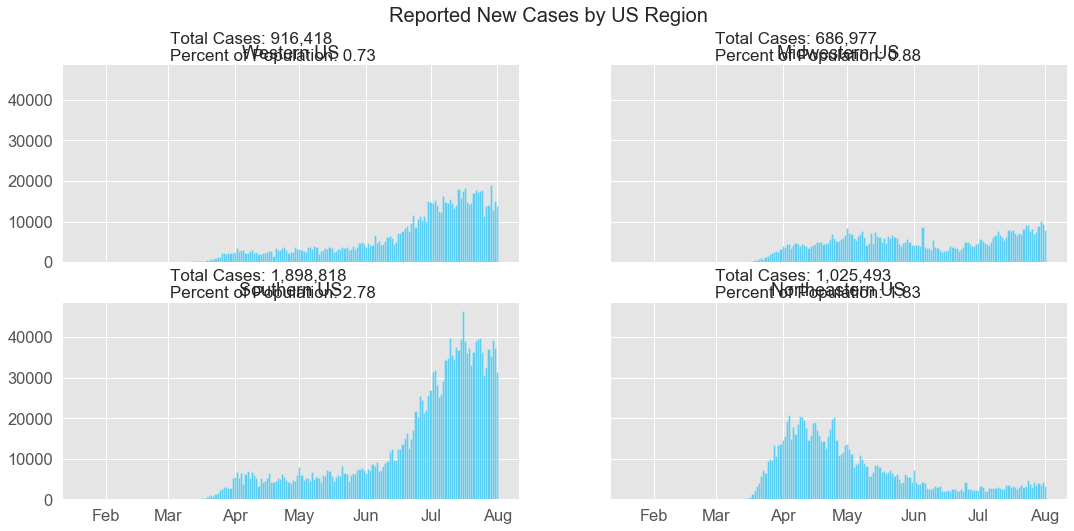

In [50]:
fig, ax = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18,8))

plt.style.use('ggplot')

# Format the dates displayed on the xaxis
date_form = DateFormatter("%b")
ax[0,0].xaxis.set_major_formatter(date_form)
ax[0,1].xaxis.set_major_formatter(date_form)
ax[1,0].xaxis.set_major_formatter(date_form)
ax[1,1].xaxis.set_major_formatter(date_form)


# Plot the Northeast
ax[1,1].bar(dailyNE.index, 
            dailyNE.new_cases,  
            color='deepskyblue',
            width=1,
            label='Northeastern',
            alpha=0.6)

# Plot the South
ax[1,0].bar(dailyS.index, 
            dailyS.new_cases,  
            color='deepskyblue',
            width=1,
            label='Southern',
            alpha=0.6)

# Plot the Midwest
ax[0,1].bar(dailyMW.index, 
            dailyMW.new_cases,  
            color='deepskyblue',
            width=1,
            label='Midwestern',
            alpha=0.6)

# Plot the West
ax[0,0].bar(dailyW.index, 
            dailyW.new_cases, 
            width=1,
            color='deepskyblue',
            label='Western',
            alpha=0.6)

# Set title
fig.suptitle('Reported New Cases by US Region', fontsize=20)
ax[0,0].set_title('Western US', fontsize=18)
ax[0,1].set_title('Midwestern US', fontsize=18)
ax[1,1].set_title('Northeastern US', fontsize=18)
ax[1,0].set_title('Southern US', fontsize=18)

# Annotate with the total number of cases and deaths. Note that the position 
# is different in the notebook and in the saved .png figure
# To view in the notebook use: (90,440), (635,440), (635,203), (90,203), respectively
ax[0,0].annotate('Total Cases: {:,}\nPercent of Population: {:.2f}'.format(int(dailyW.sum()[0]), percentW), 
                 (170,470), 
                 fontsize=17, 
                 xycoords='figure pixels')

ax[0,1].annotate('Total Cases: {:,}\nPercent of Population: {:.2f}'.format(int(dailyMW.sum()[0]), percentMW), 
                 (715,470), 
                 fontsize=17, 
                 xycoords='figure pixels')

ax[1,1].annotate('Total Cases: {:,}\nPercent of Population: {:.2f}'.format(int(dailyNE.sum()[0]), percentNE),
                 (715,233), 
                 fontsize=17, 
                 xycoords='figure pixels')

ax[1,0].annotate('Total Cases: {:,}\nPercent of Population: {:.2f}'.format(int(dailyS.sum()[0]), percentS), 
                 (170,233), 
                 fontsize=17,
                 xycoords='figure pixels')

plt.savefig('figures/Daily_US_Regions')
plt.show()

### COVID-19 in the US as a Whole
Rather than aggregating `cases` and `deaths` by `datatime` instance to get the total daily reported cases and deaths in the US, let's import a dataset that already has that information and produce a bar graph.

In [25]:
# URL to NY Times COVID-19 data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv"

# Read the values, set the indices, parse the dates, and alphabetize
usa = pd.read_csv(url, 
                  header=0, 
                  index_col=['date'], 
                  parse_dates=True).sort_index()
usa.tail(3)

,cases,deaths
date,,
2020-07-28,4366922,149774
2020-07-29,4435382,151194
2020-07-30,4502549,152431
2020-07-31,4570295,153855
2020-08-01,4628478,154909


In [26]:
usa_daily = dailyChanges(usa, ['cases','deaths'])
usa_daily.tail(3)

,new_cases,new_deaths
date,,
2020-07-28,63109.0,1324.0
2020-07-29,68460.0,1420.0
2020-07-30,67167.0,1237.0
2020-07-31,67746.0,1424.0
2020-08-01,58183.0,1054.0


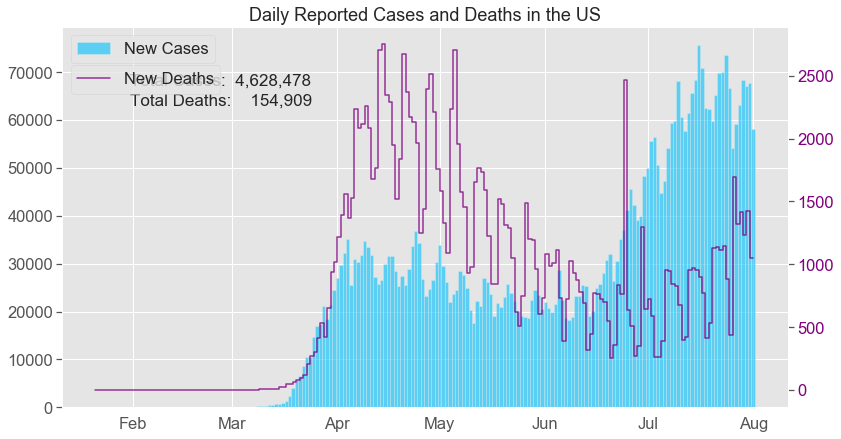

In [32]:
fig, ax = plt.subplots(figsize=(13,7))

plt.style.use('ggplot')

# Plot the new US cases
ax.bar(usa_daily.index,
       usa_daily.new_cases,
       color='deepskyblue',
       label='New Cases',
       width=1,
       alpha=0.6)

# Let the deaths be described by another pair of axis for enlargement
ax2 = ax.twinx()

# Plot the new US deaths
ax2.step(usa_daily.index,
         usa_daily.new_deaths,
         color='purple',
         label='New Deaths',
         alpha=0.8)

ax.set_title('Daily Reported Cases and Deaths in the US', fontsize=18)

# Annotate with the total number of cases and deaths. Note that the position is different in the notebook
# and in the saved .png figure. Positions for notebook: (75,322), (75,302)
ax.annotate('Total Cases:  {:,}'.format(usa.cases.values[-1]), (130,354), fontsize=17, xycoords='figure pixels')
ax.annotate('Total Deaths:    {:,}'.format(usa.deaths.values[-1]), (130,334), fontsize=17, xycoords='figure pixels')

# Formate the x-axis dates
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

# Make ax2 tick labels the color of the graph
ax2.tick_params(axis='y', labelcolor='purple')

# Format the legend and grid
ax.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.92))
ax2.grid(False)

# Save the figure
plt.savefig('figures/Daily_US')
plt.show()

## __Action item:__ 
investigate the `'Unknown'` county reported and drop it if necessary

In [28]:
# Now let's see how we can get the county information
df.loc[('Washington')].index.get_level_values(0).unique() 

Index(['Adams', 'Asotin', 'Benton', 'Chelan', 'Clallam', 'Clark', 'Columbia',
       'Cowlitz', 'Douglas', 'Ferry', 'Franklin', 'Garfield', 'Grant',
       'Grays Harbor', 'Island', 'Jefferson', 'King', 'Kitsap', 'Kittitas',
       'Klickitat', 'Lewis', 'Lincoln', 'Mason', 'Okanogan', 'Pacific',
       'Pend Oreille', 'Pierce', 'San Juan', 'Skagit', 'Skamania', 'Snohomish',
       'Spokane', 'Stevens', 'Thurston', 'Unknown', 'Wahkiakum', 'Walla Walla',
       'Whatcom', 'Whitman', 'Yakima'],
      dtype='object', name='county')

In [29]:
def plotNewCases(dataf, title, fname):
    '''
    
    '''
    fig, ax = plt.subplots(figsize=(14,8))

    _ = ax.bar(dataf.index, dataf['cases'])

    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.title(title, fontsize=25)
    plt.grid(True)
    plt.savefig(fname)

In [30]:
countiesWA = df.loc[('Washington')].index.get_level_values(0).unique() # get the counties

for i in range(len(countiesWA)):
    newcases = dailynums(df.loc[('Washington',countiesWA[i])], ['cases']).apply(abs)
    titles = ['New COVID-19 Cases '+str(c)+' County WA' for c in countiesWA]
    plotNewCases(newcases, titles[i], fname=titles[i])

NameError: name 'dailynums' is not defined

In [ ]:
'''
counties = df.loc[('New Jersey')].index.get_level_values(0).unique()

fig, ax = plt.subplots(figsize=(16,12))

for i in counties:
    df.loc[('New Jersey', i)].cases.plot()
    
plt.title("Cumulative COVID-19 Cases")
ax.legend(counties)
plt.ylabel('Cumulative Reported Cases')
plt.grid(True) 
'''

In [ ]:
dates = sorted(df.index.get_level_values(2).unique())
dates

In [ ]:
bydates = df.reset_index().set_index('date').sort_index()
bydates.loc['2020-05-31']

In [ ]:
bydates.index.unique()

In [ ]:
date = bydates.index.unique()[-1]
bydates.loc[date]

In [ ]:
d = df.loc[('Washington','King')].head()
d

In [ ]:
d[['cases','deaths']].iloc[3]

In [ ]:
dailynums(d,['cases','deaths']) # test to see if it's working 

### Underlying US County and State Boundary Maps

The data was obtained through the the US Census Bereau, which provided the `.shp` files of the boudary data. An [online file conversion tool](https://mygeodata.cloud/converter/) was then used to generate `geojson` files from the raw boundary data. 

- https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
- https://eric.clst.org/tech/usgeojson/

- https://github.com/johan/world.geo.json/tree/master/countries/USA


- [State FIPS Codes](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696)
- [County FIPS Codes](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

In [ ]:
# Getting to know GEOJSON file:
county = geopandas.read_file("data/cb_2018_us_county_20m.geojson")
county.head()

## __Action item:__ 
merge `STATEFP` and `postal code` to make it easier to read

## __Action item:__ 
filter by postal codes instead of fips for same reason

In [ ]:
# Exclude Alaska, Hawaii, American Samoa, Guam, Northern Mariana Islands, Puerto Rico, and the Virgin Islands for now
states = county[county['STATEFP'].isin(['02','15','60','66','69','72','78']) == False]

In [ ]:
states.plot(figsize=(30,20), 
            color='#3B3C6E',
            linewidth=0.1)

plt.axis('off')
plt.show()

In [ ]:
# County map of Washington State
WA = county[county['STATEFP'].isin(['53']) == True]

WA.plot(figsize=(30,20), color='#3B3C6E')
plt.axis('off')
plt.show()

### Making the Choropleths

"When making choropleths, it is important to always use a variable that is normalized for the area being plotted. Further, by using a classification scheme instead of a continuous color scale, we can make the map more easily interpretable."

To make the [choropleth map](https://geopandas.readthedocs.io/en/latest/mapping.html) I’ll need to do something like:

`covid19_county_data.plot(column=’cases’, scheme=quantile, k=12, cmap=’Purples’)`

- The color scheme is a graduated sequential scheme
    - I.e. `categorical=False`


__Action item:__ create a function that takes a geopandas DF and loops through each date and creates a choropleth based on the number of cases/100k

In [ ]:
newcasesWA = df.loc[('Washington')]

new = newcasesWA[newcasesWA.index.get_level_values(1) == dates[-1]].swaplevel(0,1).reset_index(1)
new.columns = ['NAME','new_cases']
merged = pd.merge_ordered(WA, new, how='left', on='NAME').fillna(0)
    
merged.plot()#column='new cases', cmap='BuGn', edgecolor='black') 
    
plt.title('New COVID-19 cases on '+str(d)[:10],fontsize=25)
plt.axis('off')
#plt.savefig('figs/New COVID-19 cases on '+str(d)[:10]);
plt.show()

### Animation

- Make animation of new cases vs time


- Number of total infections vs time